### Ideas
* Data Augmentation
* Fine Tuning CNN models with ResNet - Resize Images
* Use Grey Scale (i.e. duplicate HH over 3 channels and HV over 3 channels)
* Colour Composite - HH, HV , HH:HV
* Optimization -- Try RMSProp / Learning Rate
* Normalization
* Semi Supervised Learning
* Remote Sensing in Image Classification
* EDA : HH - HV relation to incident angle
* Use Edge Detection / Active Contour / Morphology
* How to identify Rough Seas
* Try Log Loss ? 


In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

import seaborn as sb

from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

#Import Keras.
from matplotlib import pyplot

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation, GlobalMaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras import initializers
from keras.optimizers import RMSprop, Adam, SGD
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping,ReduceLROnPlateau

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import load_model

In [16]:
train = pd.read_json("data/processed/train.json")
test = pd.read_json("data/processed/test.json")

In [17]:
train.head(3)
train["is_iceberg"].value_counts()

0    851
1    753
Name: is_iceberg, dtype: int64

In [22]:
# icebergs = train[train.is_iceberg==1].sample(n=9,random_state=123)
# ships = train[train.is_iceberg==0].sample(n=9,random_state=456)
# icebergs['band_1'][733]

In [19]:
# Plot band_2
# fig = plt.figure(1,figsize=(15,15))
# for i in range(9):
#     ax = fig.add_subplot(3,3,i+1)
#     arr = np.reshape(np.array(ships.iloc[i,1]),(75,75))
#     ax.imshow(arr,cmap='inferno')
    
# plt.show()

In [20]:
# Plot band_2
# fig = plt.figure(1,figsize=(15,15))
# for i in range(9):
#     ax = fig.add_subplot(3,3,i+1)
#     arr = np.reshape(np.array(icebergs.iloc[i,1]),(75,75))
#     ax.imshow(arr,cmap='inferno')
    
# plt.show()

In [23]:
print(len(train),len(test))

1604 8424


In [24]:
#Generate the training data
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_band_3=(X_band_1+X_band_2)/2
# Axis = 1 refers to adding based on the last dimension
train_image = np.concatenate([X_band_1[:, :, :, np.newaxis]
                          , X_band_2[:, :, :, np.newaxis]
                         , X_band_3[:, :, :, np.newaxis]], axis=-1)

train_target =train['is_iceberg']
train_angle = train['inc_angle']

In [25]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_band_test_3=(X_band_test_1+X_band_test_2)/2
test_image = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , X_band_test_3[:, :, :, np.newaxis]], axis=-1)

test_angle = test['inc_angle']

In [26]:
print(train_image.shape,X_band_1.shape,train_image.shape[1:])

(1604, 75, 75, 3) (1604, 75, 75) (75, 75, 3)


In [27]:
# from keras.applications.resnet50 import ResNet50

# def getResNetModel():
#     model = ResNet50(weights='imagenet')
#     return model

# resmodel = getResNetModel()
# resmodel.summary()

In [29]:
def getVggModel():
    input_1 = Input(shape=train_image.shape[1:],name='pic')
    input_2 = Input(shape=[1], name="angle")
    # Do batch normalization
    
    
    base_model = VGG16(weights='imagenet', include_top=False)
    
    x = base_model.get_layer('block5_pool').output
    x = GlobalMaxPooling2D()(x)
    x = Dense(100)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    model = Model(base_model.input,predictions)
    
    model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.001, decay=0.0),metrics=['accuracy'])    
#     model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
    return model

# Debugging
# for layers in testmodel.layers:
#     print(layers)

In [ ]:
def getModel():
    #Build keras model
    
    model=Sequential()
    
    # CNN 1
    model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 2
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 3
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    #CNN 4
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    # You must flatten the data for the dense layers
    model.add(Flatten())

    #Dense 1
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    #Dense 2
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    # Output 
    model.add(Dense(1, activation="sigmoid"))

    optimizer = Adam(lr=0.001, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

    

## Option 1
* Learning Rate - Set low than move on to high than reduce when starting to overfit
* Add more Data
* Data Augmentation
* Batch Normalization
* Add Dropout / Regularization

In [ ]:
# Splitting to test set and training set -- Option 1

indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = target_train[indices]
nb_validations_samples = int(0.3*X_train.shape[0])
X_val = X_train[-nb_validations_samples:]
# y_val = to_categorical(y_train[-nb_validations_samples:])
y_val = y_train[-nb_validations_samples:]

X_train = X_train[:-nb_validations_samples]
# y_train = to_categorical(y_train[:-nb_validations_samples])
y_train = y_train[:-nb_validations_samples]

In [ ]:
# Splitting to test set and training set -- Option 2

from sklearn.model_selection import train_test_split

# X_train, X_valid, X_angle_train, X_angle_valid, y_train, y_valid = train_test_split(X_train,
#                                     X_angle_train, y_train, random_state=123, train_size=0.75)


X_train, X_val, X_ang,X_ang_val,y_train, y_val = train_test_split(train_image,train_angle,train_target,random_state=123,test_size=0.3)

In [ ]:
gen = ImageDataGenerator(rotation_range = 10)

In [ ]:
BATCH_SIZE = 64
# STEPS_PER_EPOCH = X_train.shape[0] // BATCH_SIZE
STEPS_PER_EPOCH = 100
model = getVggModel()
model.fit_generator(gen.flow(X_train,y_train,batch_size=BATCH_SIZE)
                    ,steps_per_epoch=STEPS_PER_EPOCH,epochs=5,verbose=1,validation_data=(X_val, y_val))

In [ ]:
model.optimizer.lr = 1e-4

In [86]:
model.fit_generator(gen.flow(X_train,y_train,batch_size=BATCH_SIZE)
                    ,steps_per_epoch=STEPS_PER_EPOCH,epochs=5,verbose=1,validation_data=(X_val, y_val)
                    ,callbacks=callbacks)

Epoch 1/5
100/100 [==============================] - 14s - loss: 0.2252 - acc: 0.9096 - val_loss: 0.2143 - val_acc: 0.9044
Epoch 2/5
100/100 [==============================] - 14s - loss: 0.2095 - acc: 0.9143 - val_loss: 0.3369 - val_acc: 0.8711
Epoch 3/5
100/100 [==============================] - 14s - loss: 0.2002 - acc: 0.9210 - val_loss: 0.2279 - val_acc: 0.9044
Epoch 4/5
100/100 [==============================] - 14s - loss: 0.1955 - acc: 0.9202 - val_loss: 0.2128 - val_acc: 0.9064
Epoch 5/5
100/100 [==============================] - 15s - loss: 0.1901 - acc: 0.9239 - val_loss: 0.2429 - val_acc: 0.9064


In [88]:
preds = model.predict(X_test)
preds = preds.reshape(preds.shape[0])

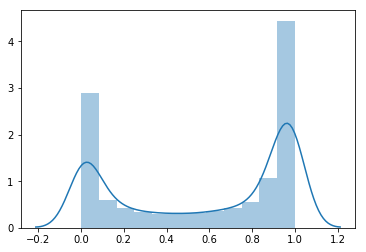

In [101]:
import seaborn as sb
sb.distplot(preds)

In [40]:
#Submission for each day.
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=preds
submission.to_csv('sub.csv', index=False)

## Option 2
* loss: 0.1170 - acc: 0.9533 - val_loss: 0.2760 - val_acc: 0.9077
* Try different Image Augmentation
* Try different Models

In [ ]:
# TODO
# Scale Images
# scaler = StandardScaler()
# scaler.fit_transform(train_image+test_image)

In [54]:
NUM_EPOCH = 80
STEPS_PER_EPOCH = 100
BATCH_SIZE = 32

gen = ImageDataGenerator(horizontal_flip = False,
                         vertical_flip = False,
                         width_shift_range = 0.,
                         height_shift_range = 0.,
                         channel_shift_range=0.,
                         zoom_range = 0.1,
                         rotation_range = 15)


#base CV structure
def get_callbacks(filepath, patience=10):
    es = EarlyStopping('val_loss', patience=10, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True,monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
    return [es, msave,reduce_lr_loss]
def myBaseCrossTrain(feature, target, model):
    folds = list(StratifiedKFold(n_splits=4, shuffle=True, random_state=16).split(feature, target))
    y_test_pred_log = 0
    y_valid_pred_log = np.zeros(feature.shape[0])
    for j, (train_idx, valid_idx) in enumerate(folds):
        print('\n===================FOLD=',j)
        X_train_cv = feature[train_idx]
        y_train_cv = target[train_idx]
        X_holdout = feature[valid_idx]
        Y_holdout= target[valid_idx]
        file_path = "%s_model_weights.hdf5"%j
        callbacks = get_callbacks(filepath=file_path, patience=10)
        
        
        model.fit_generator(gen.flow(X_train_cv,y_train_cv,batch_size=BATCH_SIZE),
                  steps_per_epoch=STEPS_PER_EPOCH,
                  epochs=NUM_EPOCH,
                  verbose=1,
                  validation_data=(X_holdout, Y_holdout),
                  callbacks=callbacks)

        #Getting the Best Model in this fold
        model.load_weights(filepath=file_path)
        
        #Getting Training Score
        score = model.evaluate(X_train_cv, y_train_cv, verbose=0)
        print('Train loss:', score[0])
        print('Train accuracy:', score[1])
        #Getting Test Score
        score = model.evaluate(X_holdout, Y_holdout, verbose=0)
        print('Validation loss:', score[0])
        print('Validation accuracy:', score[1])

        #Getting validation Score.
        pred_valid=model.predict(X_holdout)
        y_valid_pred_log[valid_idx] = pred_valid.reshape(pred_valid.shape[0])

        #Getting Test Scores
        single_fold_test = model.predict(test_image)
        y_test_pred_log+=single_fold_test.reshape(single_fold_test.shape[0])
    
    # Get the average prediction score from the 4 models with cross validation
    y_test_pred_log=y_test_pred_log/4

    print('\nLog Loss Validation= ',log_loss(target, y_valid_pred_log))
    return y_test_pred_log

In [ ]:
preds=myBaseCrossTrain(train_image, train_target,model=getVggModel())


===================FOLD= 0
Epoch 1/80
100/100 [==============================] - 10s - loss: 0.5124 - acc: 0.7395 - val_loss: 5.2409 - val_acc: 0.5299
Epoch 2/80
100/100 [==============================] - 9s - loss: 0.4145 - acc: 0.8134 - val_loss: 0.6622 - val_acc: 0.7612
Epoch 3/80
100/100 [==============================] - 9s - loss: 0.3539 - acc: 0.8465 - val_loss: 2.3056 - val_acc: 0.5473
Epoch 4/80
100/100 [==============================] - 10s - loss: 0.2973 - acc: 0.8714 - val_loss: 0.3007 - val_acc: 0.8756
Epoch 5/80
100/100 [==============================] - 8s - loss: 0.2703 - acc: 0.8799 - val_loss: 0.3115 - val_acc: 0.8905
Epoch 6/80
100/100 [==============================] - 9s - loss: 0.2547 - acc: 0.8954 - val_loss: 0.2755 - val_acc: 0.8930
Epoch 7/80
100/100 [==============================] - 9s - loss: 0.2351 - acc: 0.9075 - val_loss: 0.2929 - val_acc: 0.9030
Epoch 8/80
100/100 [==============================] - 9s - loss: 0.2188 - acc: 0.9129 - val_loss: 0.2663 - va

In [ ]:
#0.1639 on the public leaderboard
gen = ImageDataGenerator(horizontal_flip = True,vertical_flip = True,width_shift_range = 0.,height_shift_range = 0.,channel_shift_range=0,zoom_range = 0.2,rotation_range = 10)
galaxyModel.fit(X_train_cv, y_train_cv,batch_size=24,epochs=80,verbose=1,validation_data=(X_holdout, Y_holdout),callbacks=callbacks)

Train loss: 0.0793685312089
Train accuracy: 0.975913620866
Test loss: 0.258395348191
Test accuracy: 0.895

Log Loss Validation=  0.211045624827

In [ ]:
#Submission for each day.
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=preds
submission.to_csv('sub.csv', index=False)